<br />
<div style="text-align: center;">
<font size="7">Pyro入門メモ</font>
</div>
<br />
<div style="text-align: right;">
</div>


Pyroは確率的プログラミング言語であり、確率モデルを実装することができます。<br>
Pytorchで実装されている初等的な確率関数を利用でき、高速な計算やautogradが利用できます。<br>
また、変換を用いることで好きな関数を設計することもできます。<br>

In [24]:
#pyroの環境設定は他のサイトを参考にしてください
import torch
from torch import autograd
import torch.distributions.constraints as constraints
import pyro.distributions as dist
import pyro
from pyro.optim import Adam
import matplotlib.pyplot as plt

# 基本文法
## 確率関数
pytorch,pyroそれぞれで確率関数は用意されており、例として以下のような記法で書けます<br>
pyroでは以下のような書き方をします。<br>
似ているが、ここで注意する相違点として、関数に名前をつける必要があります。
### 正規分布
どちらも平均0、分散1の正規分布をpytorch、pyroそれぞれで実装

In [4]:
loc,scale = 0.,1.
#pytorch
x_torch = torch.distributions.Normal(loc, scale).sample() # create a normal distribution object
print("sample:", x_torch)

#pyro
x_pyro = pyro.sample("my_sample", pyro.distributions.Normal(loc,scale))
print("sample:", x_pyro)

sample: tensor(-0.1630)
sample: tensor(-0.5524)


### ベルヌーイ分布
二つの事象が等確率(0.5)で発生するベルヌーイ分布をpytorch,pyroそれぞれで実装

In [5]:
#pytorch
x_torch = torch.distributions.Bernoulli(0.5).sample()
print("sample:", x_torch)

#pyro
x_pyro = pyro.sample("pyro_ber", pyro.distributions.Bernoulli(0.5))
print("sample:", x_pyro)

sample: tensor(0.)
sample: tensor(1.)


## モデル定義
次に簡単なモデルを実装してみます
### 幾何分布
pyroにおいて、確率関数として予めベルヌーイ分布は与えられている。<br>
これを用いて幾何分布を以下のように実装できる。<br>
これは再帰的な定義になっているが、各反復の中で、それぞれ異なる名前で関数を定義する必要があるため、"x_{}"のようにして反復回数をもとにした名前を与えている<br>
他にもかなり自由度の高い実装が行えます。他の応用例は後に実装する予定。

In [6]:
def geometric(p, t=None):
    if t is None:
        t = 0
    x = pyro.sample("x_{}".format(t), pyro.distributions.Bernoulli(p))
    if x.item() == 1:
        return 0
    else:
        return 1 + geometric(p, t + 1)

print("sample:",geometric(0.5))

sample: 1


## 変分推論におけるモデル定義
変分推定におけるモデルの主な構成要素としては、観測、パラメータ、潜在変数があります。これらはPyroにおいては、<br>
・観測 : obsを与えたpyro.sample<br>
・潜在変数 : pyro.sample<br>
・パラメータ : pyro.param<br>
の対応関係で与えられます。実際の利用法は以降の例の中で確認してください。

# 推定
確率モデルを議論する際、観測されたデータからそのモデルを推定するというのは重要な問題設定であることが多い。<br>
例として以下のようなモデルを用います。<br>
これは分散1.0の正規分布weightから得たサンプルを平均として、分散0.7の正規分布measurementからサンプルを得るというものである<br>
weightが実際の重さを表す分布であり、これを観測した結果がmeasurementということになる<br>
measurementには正規分布分のノイズが乗っている。<br>
正規分布を二回重ねても正規分布になるわけだが、一つ目のweightの分散が大きいため、以下のように当然大きなブレを持つサンプルが得られる

In [7]:
def scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    return pyro.sample("measurement", dist.Normal(weight, 0.7))
print("sample:", scale(0))

sample: tensor(-0.1271)


## 条件付け
ここで一つ目のweightの出力を0に限定して条件付けしてみます。<br>
つまり、二つ目の正規分布の平均を0で条件付けしたことになっており、上で定義した関数scaleはただの分散0.7の正規分布になります。<br>
条件付けした関数conditioned_scaleの引数はscaleの引数guessです。

In [8]:
conditioned_scale = pyro.condition(scale, data={"weight": 0})
print("sample:",conditioned_scale(0)) #分散が小さくなっている

#以下のようにweightを引数とした関数として定義し、自由な値で条件付けできるようにも設計できる。
def deferred_conditioned_scale(weight, guess):
    return pyro.condition(scale, data={"weight": weight})(guess)

sample: tensor(0.9933)


以下のようにサンプルのsample自体の値をobsで決めることができる<br>
ただし、これはハードコーディングになっているので、特別な場合以外はobserveを用いてモデルの関数形自体は保持しておいた方が良いと思われます。

In [10]:
def scale_obs(guess):  # equivalent to conditioned_scale above
    weight = pyro.sample("weight", dist.Normal(guess, 1.), obs=0)
     # here we condition on measurement == 9.5
    return pyro.sample("measurement", dist.Normal(weight, 1))
print("sample:", scale_obs(0))

sample: tensor(1.2934)


/usr/local/lib/python3.6/site-packages/pyro/primitives.py:83: RuntimeWarning: trying to observe a value outside of inference at weight
  RuntimeWarning)


学習時に重要な用い方としては、観測されたデータを与えることによる条件付けを行い、パラメータの調整を行うことであり、<br>
これも今回の例では以下のように行えます。

In [11]:
conditioned_scale = pyro.condition(scale, data={"measurement": 9.5})
print("sample:",conditioned_scale(0)) #観測結果は9.5に固定される

sample: 9.5


## 学習
最初に言及した通り、得られた観測データからモデルのパラメータを推定する<br>
### 提案分布
pyroではguideと呼ばれる関数を提案分布として設計し、重点サンプリング、MCMC、SVIを実行できる。(今後他の手法も追加予定らしい?)<br>
提案分布はなるべく目標分布と重なりの多いものを選んだ方が受容率が高まり収束が速くなるため望ましいです。
### 変分推論
実際に変分推論を用いて学習を行ってみます。<br>
ここでも上記の二つの正規分布を重ねたモデルについて考えてみます。<br>
model : 事後分布のモデル。出力については観測データを与え、その尤度を測ることができる。<br>
guide : 変分推論においては、変分パラメータとして定義する。パラメータが必要であり、これはpyro.param("name", tensor)で与える


a =  9.159270286560059
b =  0.553314745426178


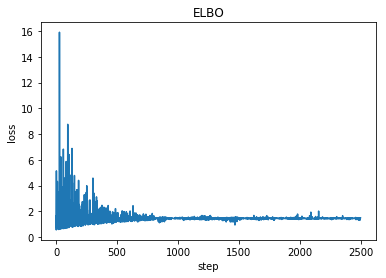

In [25]:
#上記で定義したものと同じモデル
def scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    return pyro.sample("measurement", dist.Normal(weight, 0.7))
#観測データを9.5に固定
conditioned_scale = pyro.condition(scale, data={"measurement": 9.5})

def scale_parametrized_guide(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.))
    return pyro.sample("weight", dist.Normal(a, torch.abs(b)))

guess = 8.5

pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_scale,
                     guide=scale_parametrized_guide,
                     optim=pyro.optim.SGD({"lr": 0.001, "momentum":0.1}),
                     loss=pyro.infer.Trace_ELBO())


losses, a,b  = [], [], []
num_steps = 2500
for t in range(num_steps):
    losses.append(svi.step(guess))
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('a = ',pyro.param("a").item())
print('b = ', pyro.param("b").item())

In [36]:
dist.normal

AttributeError: module 'pyro.distributions' has no attribute 'normal'

In [620]:
# set up the optimizer
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = pyro.optim.Adam(adam_params)

# setup the inference algorithm
svi = pyro.infer.SVI(model, guide, optimizer, loss=pyro.infer.Trace_ELBO())

n_steps = 5000
# do gradient steps
for step in range(n_steps):
    svi.step(data)

In [636]:
from __future__ import print_function
import math
import os
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist

In [637]:
# これは私達のテスト・フレームワーク内で notebook  を実行するためです。
smoke_test = ('CI' in os.environ)
n_steps = 2 if smoke_test else 2000

# 検証を有効にする (e.g. 分布のパラメータを検証する)
pyro.enable_validation(True)

# REPL 内にいる場合に param ストアをクリア
pyro.clear_param_store()

# 6 の観測された表と 4 の観測された裏を持つ幾つかのデータを作成します。
data = []
for _ in range(6):
    data.append(torch.tensor(1.0))
for _ in range(4):
    data.append(torch.tensor(0.0))

def model(data):
    # beta 事前分布を制御するハイパーパラメータを定義する。
    alpha0 = torch.tensor(10.0)
    beta0 = torch.tensor(10.0)
    # beta 事前分布から f をサンプリング
    f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    # 観測データに渡りループ
    for i in range(len(data)):
        # observe datapoint i using the bernoulli likelihood
        pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])

def guide(data):
    # Pyro で 2 つの変分パラメータを登録します
    # - both parameters will have initial value 15.0.
    # - because we invoke constraints.positive, the optimizer
    # will take gradients on the unconstrained parameters
    # (which are related to the constrained parameters by a log)
    alpha_q = pyro.param("alpha_q", torch.tensor(15.0),
                         constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(15.0),
                        constraint=constraints.positive)
    # sample latent_fairness from the distribution Beta(alpha_q, beta_q)
    pyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))

# setup the optimizer
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# do gradient steps
for step in range(n_steps):
    svi.step(data)
    if step % 100 == 0:
        print('.', end='')

# grab the learned variational parameters
alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()

# here we use some facts about the beta distribution
# compute the inferred mean of the coin's fairness
inferred_mean = alpha_q / (alpha_q + beta_q)
# compute inferred standard deviation
factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
inferred_std = inferred_mean * math.sqrt(factor)

print("\nbased on the data and our prior belief, the fairness " +
      "of the coin is %.3f +- %.3f" % (inferred_mean, inferred_std))

....................
based on the data and our prior belief, the fairness of the coin is 0.528 +- 0.090


In [32]:
def scale(guess):
    weight = pyro.sample("weight", dist.normal, guess, Variable(torch.ones(1)))
    return pyro.sample("measurement", dist.normal, weight, Variable(torch.Tensor([0.75])))

guess = torch.Tensor([8.5])
measurement = torch.Tensor([9.5])
conditioned_scale = pyro.condition(scale, data={"measurement": measurement})
marginal = pyro.infer.Marginal(
    pyro.infer.Importance(conditioned_scale, num_samples=100), sites=["weight"])
print(marginal(guess))
plt.hist([marginal(guess)["weight"].data[0] for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#")

AttributeError: module 'pyro.infer' has no attribute 'Marginal'

In [640]:
pyro.param("alpha_q")

tensor(15.7260, grad_fn=<AddBackward0>)

In [634]:
guide(data)

None


In [617]:
data = [1.]

In [597]:
posterior = pyro.infer.Importance(scale, num_samples=100)
posterior

In [603]:
pyro.param("name", torch.tensor(1.))

tensor(1., requires_grad=True)

In [462]:
def deferred_conditioned_scale(measurement, guess):
    return pyro.condition(scale, data={"measurement": measurement})(guess)
deferred_conditioned_scale(12,10)

12

In [88]:
def weather():
    cloudy = torch.distributions.Bernoulli(0.3).sample()
    cloudy = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 15.0, 'sunny': 25.0}[cloudy]
    scale_temp = {'cloudy': 5.0, 'sunny': 10.0}[cloudy]
    temp = torch.distributions.Normal(mean_temp, scale_temp).rsample()
    return cloudy, temp.item()

In [101]:
weather()

('sunny', 16.511615753173828)

In [16]:
mu = torch.zeros(1)
sigma = torch.ones(1)

In [17]:
x = dist.normal(mu, sigma)

AttributeError: module 'pyro.distributions' has no attribute 'normal'

In [19]:
d = torch.randn(10)
model(d)